In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json



In [2]:
!kaggle datasets download -d ronakgohil/license-plate-dataset


Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [3]:
!unzip -q license-plate-dataset.zip -d data

In [4]:
#verify gpu is working
!nvidia-smi

Sun Apr 13 21:23:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
#import some libraries that may be useful

#standard libraries
import glob
import json
import os
import random

#data processing and visualization libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

#machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import product

#PyTorch libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import transforms

#TensorFlow/ keras libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#define data paths
data_directory= 'data/archive'
train_image_directory= os.path.join(data_directory, 'images/train')
val_images_directory= os.path.join(data_directory, 'images/val')
train_label_directory= os.path.join(data_directory, 'labels/train')
val_labels_directory= os.path.join(data_directory, 'labels/val')

In [7]:
#covert YOLO format annotations to bounding box coordinates
def convert_yolo_to_coor(label_path, image_width, image_height):
  with open(label_path, 'r') as f:
    lines= f.readlines()

    boxes= []

    for line in lines:
      cls, x_center, y_center, width, height= map(float, line.strip().split())

      x_center *= image_width
      y_center *= image_height
      width *= image_width
      height *= image_height

      x_min= x_center - width / 2
      y_min= y_center - height / 2
      x_max= x_center + width / 2
      y_max= y_center + height / 2

      boxes.append([x_min, y_min, x_max, y_max])

    return boxes

use OpenCV for image processing

In [8]:
#pair images with object locations
def load_dataset(image_directory, label_directory):
  images= []
  labels= []
  image_paths= sorted(glob.glob(os.path.join(image_directory, '*.jpg')))

  for image_path in image_paths:
    label_filename= os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    label_path= os.path.join(label_directory, label_filename)

    image= cv2.imread(image_path)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width= image.shape[:2]

    boxes= convert_yolo_to_coor(label_path, image_width, image_height)

    box= boxes[0]
    images.append(image)
    labels.append(box)

  return images, labels

In [9]:
#load in the training and validation data
train_images, train_labels= load_dataset(train_image_directory, train_label_directory)
print(f"Loaded {len(train_images)} training images and {len(train_labels)} training labels")

val_images, val_labels= load_dataset(val_images_directory, val_labels_directory)
print(f"Loaded {len(val_images)} validation images and {len(val_labels)} validation labels")

Loaded 1526 training images and 1526 training labels
Loaded 169 validation images and 169 validation labels


## Data Exploration

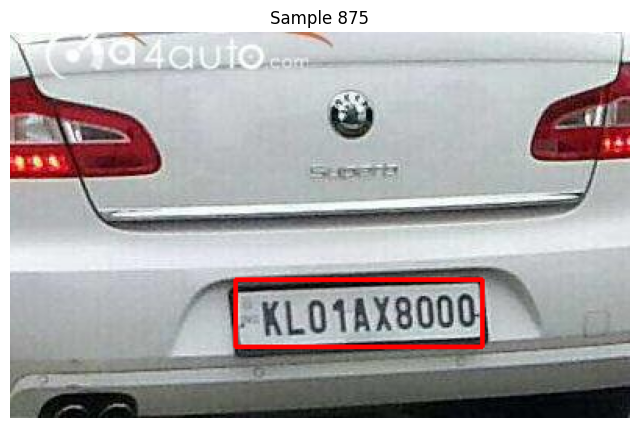

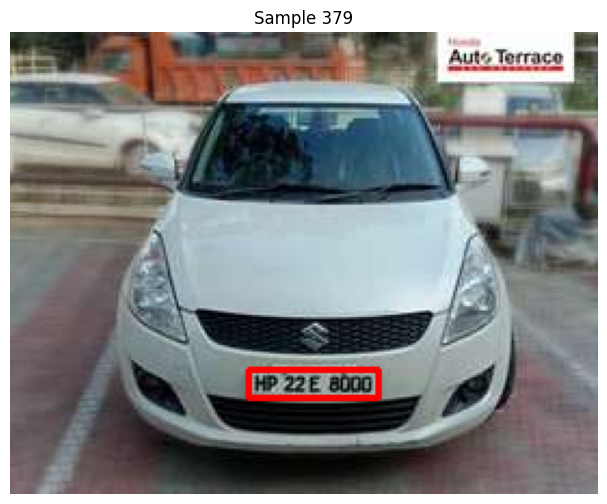

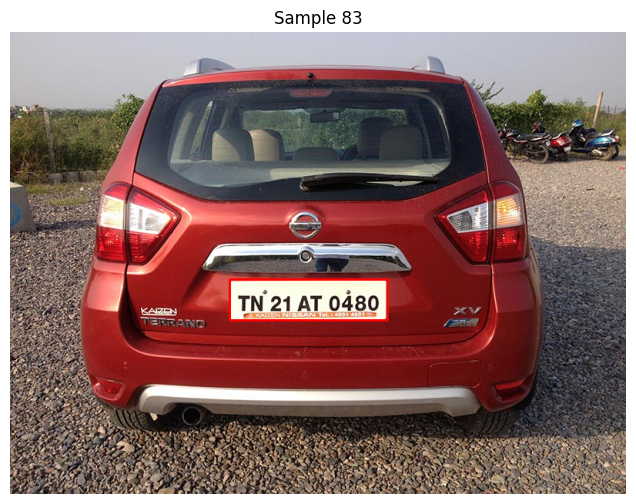

Average box width:  168.89 pixels
Average box height:  54.11 pixels
Image shapes: {(742, 582, 3), (351, 451, 3), (720, 540, 3), (1024, 768, 3), (568, 272, 3), (423, 541, 3), (127, 272, 3), (1000, 895, 3), (480, 640, 3), (415, 500, 3), (378, 500, 3), (284, 272, 3), (354, 554, 3), (689, 851, 3), (493, 650, 3), (908, 1292, 3), (450, 546, 3), (525, 700, 3), (435, 358, 3), (1073, 424, 3), (327, 271, 3), (1032, 1351, 3), (304, 272, 3), (752, 731, 3), (1080, 1050, 3), (1080, 810, 3), (316, 435, 3), (271, 500, 3), (2252, 2281, 3), (406, 672, 3), (1600, 1200, 3), (902, 1028, 3), (347, 886, 3), (436, 717, 3), (179, 272, 3), (869, 1016, 3), (430, 500, 3), (627, 887, 3), (809, 1278, 3), (251, 580, 3), (1080, 1080, 3), (196, 341, 3), (562, 1000, 3), (662, 795, 3), (290, 509, 3), (1080, 1612, 3), (689, 737, 3), (601, 960, 3), (1080, 1361, 3), (605, 272, 3), (1080, 1110, 3), (1076, 1630, 3), (764, 1567, 3), (621, 322, 3), (224, 400, 3), (431, 416, 3), (136, 272, 3), (768, 1024, 3), (1080, 1920, 3), (

In [10]:
#function to display image with bounding box
def plot_image_with_box(image, box, title= ''):
  image_copy= image.copy()
  x_min, y_min, x_max, y_max= map(int, box)
  cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

  plt.figure(figsize= (8, 6))
  plt.imshow(image_copy)
  plt.title(title)
  plt.axis('off')
  plt.show()

#display 3 random samples
random_indices= random.sample(range(len(train_images)), 3)

for idx in random_indices:
  plot_image_with_box(train_images[idx], train_labels[idx], f"Sample {idx}")

box_widths= [box[2] - box[0] for box in train_labels]
box_heights= [box[3] - box[1] for box in train_labels]

print(f"Average box width: {np.mean(box_widths): .2f} pixels")
print(f"Average box height: {np.mean(box_heights): .2f} pixels")
print(f"Image shapes: {set([img.shape for img in train_images])}")

## Preprocess Data

In [11]:
#preprocessing parameters
IMAGE_SIZE= (128, 128)
BATCH_SIZE= 32

In [12]:
#preprocessing function
def preprocess_image_and_label(image, box, image_size=IMAGE_SIZE):
  original_height, original_width= image.shape[:2]

  image= cv2.resize(image, image_size)
  image= image / 255.0

  x_min, y_min, x_max, y_max= box
  x_min= x_min * image_size[0] / original_width
  x_max= x_max * image_size[0] / original_width
  y_min= y_min * image_size[1] / original_height
  y_max= y_max * image_size[1] / original_height

  return image, np.array([x_min, y_min, x_max, y_max])

In [13]:
#function to apply preprocessing
def preprocess_dataset(images, labels):
  preprocessed_images= []
  preprocessed_labels= []

  for img, box in zip(images, labels):
    p_img, p_box= preprocess_image_and_label(img, box)
    preprocessed_images.append(p_img)
    preprocessed_labels.append(p_box)

  return np.array(preprocessed_images), np.array(preprocessed_labels)

In [14]:
#create a train, val, test split
X_train, X_test, y_train, y_test= train_test_split(train_images,
                                                   train_labels,
                                                   test_size= 0.1,
                                                   random_state= 24)
X_val, y_val= val_images, val_labels

print(f"Training set {len(X_train)} images")
print(f"Validation set {len(X_val)} images")
print(f"Test set {len(X_test)} images")

Training set 1373 images
Validation set 169 images
Test set 153 images


In [15]:
#preprocess all data subsets
X_train, y_train= preprocess_dataset(X_train, y_train)
X_val, y_val= preprocess_dataset(X_val, y_val)
X_test, y_test= preprocess_dataset(X_test, y_test)

Use TensorFlow/ Keras for model building

In [16]:
#create TensorFlow datasets
train_dataset= tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.shuffle(buffer_size= len(X_train)).batch(BATCH_SIZE)

val_dataset= tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset= val_dataset.batch(BATCH_SIZE)

test_dataset= tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(BATCH_SIZE)

## Baseline Model

Helpful links
https://victorzhou.com/blog/keras-cnn-tutorial/

https://www.tensorflow.org/tutorials/images/cnn

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [17]:
#build baseline CNN model
def build_baseline_model(input_shape= (128, 128, 3)):
  model= Sequential([Conv2D(32, (3, 3), activation= 'relu', input_shape= input_shape),
                      MaxPooling2D((2, 2)),
                     Conv2D(64, (3, 3), activation= 'relu'),
                     MaxPooling2D((2, 2)),
                     Conv2D(128, (3, 3)),
                     MaxPooling2D((2,2)),
                     Flatten(),
                     Dense(128, activation= 'relu'),
                     Dropout(0.5),
                     Dense(4)])
  return model

In [18]:
#compile baseline model
baseline_model= build_baseline_model()
baseline_model.compile(optimizer= Adam(learning_rate=0.001),
                       loss= 'mse',
                       metrics= ['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#train the model
baseline_history= baseline_model.fit(train_dataset,
                                     validation_data= val_dataset,
                                     epochs= 20,
                                     verbose= 1)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 2209.4570 - mae: 38.0074 - val_loss: 763.2952 - val_mae: 23.1733
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 727.7722 - mae: 21.4833 - val_loss: 660.3949 - val_mae: 21.5056
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 645.2991 - mae: 20.2586 - val_loss: 633.2764 - val_mae: 20.9364
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 572.1608 - mae: 18.7607 - val_loss: 566.3419 - val_mae: 19.7252
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 492.6821 - mae: 17.3300 - val_loss: 605.8723 - val_mae: 20.3075
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 522.7604 - mae: 18.1436 - val_loss: 657.7587 - val_mae: 20.9723
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 462.9136 - mae: 16.7367 - val_loss: 539.0881 - val_mae: 19.0566
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 441.6768 - mae: 16.5200 - val_loss: 527.3644 - val_mae: 18.6113
Epoch 9/20
43/

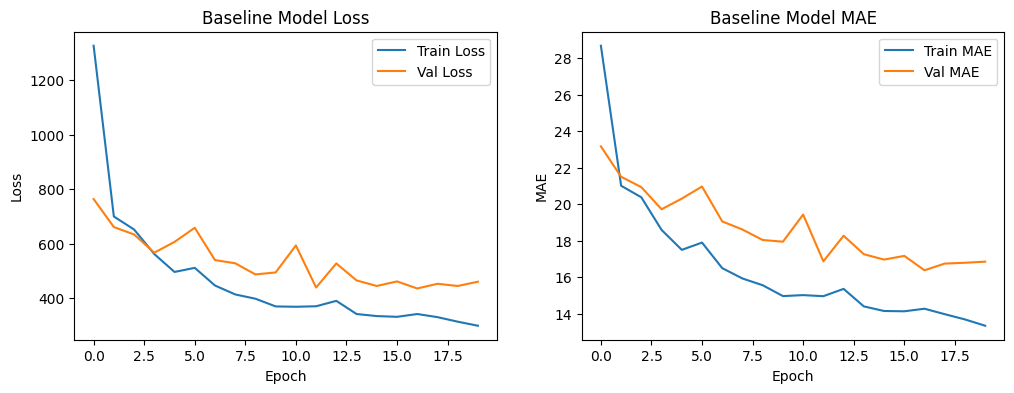

In [20]:
#plot training history
plt.figure(figsize= (12, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['loss'], label= 'Train Loss')
plt.plot(baseline_history.history['val_loss'], label= 'Val Loss')
plt.title("Baseline Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['mae'], label= 'Train MAE')
plt.plot(baseline_history.history['val_mae'], label= 'Val MAE')
plt.title("Baseline Model MAE")
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#function to build model with variable parameters
def build_model(filters, dense_units, learning_rate, input_shape= (128, 128, 3)):
   model= Sequential([Conv2D(filters[0], (3, 3), activation= 'relu', input_shape= input_shape),
                      MaxPooling2D((2, 2)),
                     Conv2D(filters[1], (3, 3), activation= 'relu'),
                     MaxPooling2D((2, 2)),
                     Conv2D(filters[2], (3, 3), activation= 'relu'),
                     MaxPooling2D((2,2)),
                     Flatten(),
                     Dense(dense_units, activation= 'relu'),
                     Dropout(0.5),
                     Dense(4)])

#grid search parameters
param_grid= {'filters': [(32, 64, 128), (64, 128, 256)],
             'dense_units': [64, 128],
             'learning_rate': [0.001, 0.0001]}

#perform grid search
best_val_loss= float('inf')
best_model= None
best_params= None
results= []

